# Library Importing

In [61]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

In [62]:
movies = pd.read_csv('movie.csv')

In [63]:
ratings = pd.read_csv('rating.csv')

In [64]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [65]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [66]:
movies.shape

(9742, 3)

In [67]:
ratings.shape

(100836, 4)

# Rating Plot

<AxesSubplot:>

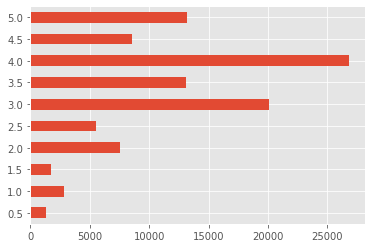

In [68]:
ratings_dist = ratings.rating.value_counts().sort_index()
ratings_dist.plot(kind='barh')

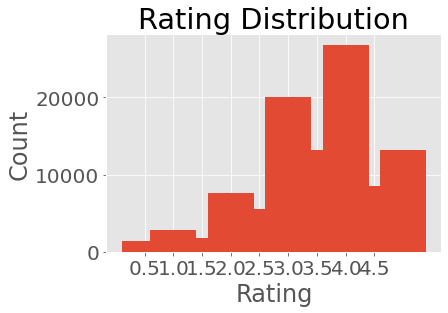

In [69]:
plt.rc("font", size=20)
plt.bar(x=ratings_dist.index, height=ratings_dist.values)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0.5, 5, 0.5))
plt.ylabel('Count')
plt.show()

# Active Users and Movies Population

In [70]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this dataset


In [71]:
ratings_cnt = pd.DataFrame(ratings.groupby('rating').size(), columns=['cnt'])
ratings_cnt

,cnt
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [72]:
total_rating_cnt = ratings_cnt.cnt.sum()
total_rating_cnt

100836

# Count

In [73]:
total_cnt = num_users*num_items
total_cnt

5931640

In [74]:
rating_zero_cnt = total_cnt - total_rating_cnt
rating_zero_cnt = pd.DataFrame(rating_zero_cnt, index=[0], columns=['cnt'])
rating_zero_cnt

,cnt
0,5830804


In [75]:
rating_cnt = pd.concat([rating_zero_cnt, ratings_cnt])
rating_cnt

,cnt
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


# Log Count

In [76]:
rating_log_cnt = np.log(rating_cnt)
rating_log_cnt.columns = ['log_cnt']
rating_log_cnt

,log_cnt
0.0,15.578665
0.5,7.222566
1.0,7.941296
1.5,7.490529
2.0,8.929435
2.5,8.621553
3.0,9.905835
3.5,9.483112
4.0,10.196829
4.5,9.053804


In [77]:
ratings_log_cnt_cnt = pd.concat([rating_log_cnt, rating_cnt], axis=1)
ratings_log_cnt_cnt

,log_cnt,cnt
0.0,15.578665,5830804
0.5,7.222566,1370
1.0,7.941296,2811
1.5,7.490529,1791
2.0,8.929435,7551
2.5,8.621553,5550
3.0,9.905835,20047
3.5,9.483112,13136
4.0,10.196829,26818
4.5,9.053804,8551


#### Movies Count

In [78]:
movie_cnt = ratings.groupby('movieId').size()
movie_cnt = pd.DataFrame(movie_cnt, columns=['cnt'])
movie_cnt.head()

,cnt
movieId,
1,215
2,110
3,52
4,7
5,49


In [79]:
movie_cnt.sum()

cnt    100836
dtype: int64

In [80]:
movies_cnt_q = pd.DataFrame(movie_cnt.cnt.quantile(q=np.arange(1,0.6,-0.05)))
movies_cnt_q.head()

,cnt
1.00,329.0
0.95,47.0
0.90,27.0
0.85,17.0
0.80,12.0


In [81]:
pop_thr = 50
popular_movies = list(set(movie_cnt.query('cnt >= @pop_thr').index))
popular_movies = pd.Series(popular_movies, name='popular_movies')
popular_movies

0          1
1          2
2          3
3          6
4          7
       ...  
445     2006
446     2011
447     2012
448     2028
449    30707
Name: popular_movies, Length: 450, dtype: int64

In [82]:
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
df_ratings_drop_movies

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100657,610,106782,4.5,1479542155
100672,610,109374,4.5,1493845137
100673,610,109487,3.5,1493845041
100701,610,112852,4.5,1493845402


In [83]:
print('Shape of the original ratings data', ratings.shape)
print('Shape of the ratings after unpopular movies', df_ratings_drop_movies.shape)

Shape of the original ratings data (100836, 4)
Shape of the ratings after unpopular movies (41360, 4)


#### User Count

In [84]:
user_cnt = df_ratings_drop_movies.groupby('userId').size()
user_cnt = pd.DataFrame(user_cnt, columns=['cnt'])
user_cnt.head()

,cnt
userId,
1,117
2,15
3,6
4,84
5,34


In [85]:
pop_thr = 50
active_users = list(set(user_cnt.query('cnt >= @pop_thr').index))
active_users = pd.Series(active_users, name='active_users')
active_users

0        1
1      514
2        4
3      517
4        6
      ... 
263    607
264    495
265    608
266    509
267    510
Name: active_users, Length: 268, dtype: int64

In [89]:
active_users_q = pd.DataFrame(active_users.quantile(np.arange(1,0.6,-0.05)))
active_users_q

,active_users
1.00,610.00
0.95,593.65
0.90,563.20
0.85,521.90
0.80,478.80
0.75,447.25
0.70,418.90
0.65,380.55


In [94]:
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
df_ratings_drop_users

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100657,610,106782,4.5,1479542155
100672,610,109374,4.5,1493845137
100673,610,109487,3.5,1493845041
100701,610,112852,4.5,1493845402


In [95]:
print('Shape of the original ratings data', ratings.shape)
print('Shape of the ratings after unpopular movies', df_ratings_drop_users.shape)

Shape of the original ratings data (100836, 4)
Shape of the ratings after unpopular movies (32999, 4)


#### Final datasets

In [96]:
df_ratings_drop_movies

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100657,610,106782,4.5,1479542155
100672,610,109374,4.5,1493845137
100673,610,109487,3.5,1493845041
100701,610,112852,4.5,1493845402


In [97]:
df_ratings_drop_users['userId']

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100657,610,106782,4.5,1479542155
100672,610,109374,4.5,1493845137
100673,610,109487,3.5,1493845041
100701,610,112852,4.5,1493845402


# Colaborative Filtering

In [580]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating')
movie_user_mat

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,4.5,2.5,NaN,4.5,3.5,4.0,NaN,...,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,...,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN
3,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
6,4.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0
7,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
109487,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.5,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
112852,NaN,NaN,NaN,NaN,1.5,NaN,NaN,4.5,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5


In [581]:
def FunkSVD(ratings_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[1] # number of rows in the matrix
    n_movies = ratings_mat.shape[0] # number of movies in the matrix
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat)) # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(latent_features, n_users) # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(n_movies, latent_features) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    
    print(n_movies, n_users) 
    # for each iteration
    for iteration in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        # For each user-movie pair
        for i in range(n_movies):

            for j in range(n_users):
                # if the rating exists
                if ratings_mat.iloc[i, j] > 0:
                    #print('not null', (i, j), ratings_mat.iloc[i, j])
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_mat.iloc[i, j] - np.dot(movie_mat[i, :], user_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[k, j] += learning_rate * (2*diff*user_mat[k, j])
                        movie_mat[i, k] += learning_rate * (2*diff*movie_mat[i, k])

        # print results for iteration
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, movie_mat 

In [582]:
movie_user_mat.iloc[0, 0]

4.0

In [585]:
user_mat, movie_mat = FunkSVD(movie_user_mat)

Optimizaiton Statistics
Iterations | Mean Squared Error 
450 268
1 		 1.926296
2 		 1.747069
3 		 1.599806
4 		 1.479253
5 		 1.380620
6 		 1.299740
7 		 1.233115
8 		 1.177882
9 		 1.131740
10 		 1.092871
11 		 1.059843
12 		 1.031540
13 		 1.007092
14 		 0.985818
15 		 0.967183
16 		 0.950762
17 		 0.936219
18 		 0.923281
19 		 0.911725
20 		 0.901369
21 		 0.892061
22 		 0.883672
23 		 0.876094
24 		 0.869236
25 		 0.863017
26 		 0.857368
27 		 0.852230
28 		 0.847550
29 		 0.843283
30 		 0.839386
31 		 0.835825
32 		 0.832567
33 		 0.829585
34 		 0.826851
35 		 0.824344
36 		 0.822044
37 		 0.819931
38 		 0.817989
39 		 0.816204
40 		 0.814562
41 		 0.813050
42 		 0.811658
43 		 0.810376
44 		 0.809194
45 		 0.808104
46 		 0.807099
47 		 0.806171
48 		 0.805316
49 		 0.804526
50 		 0.803796
51 		 0.803123
52 		 0.802500
53 		 0.801925
54 		 0.801394
55 		 0.800903
56 		 0.800449
57 		 0.800029
58 		 0.799641
59 		 0.799283
60 		 0.798951
61 		 0.798644
62 		 0.798361
63 		 0.798099

In [587]:
movieprint(np.dot(movie_mat, user_mat))
print(movie_user_mat)

[[4.02016393 3.49498771 4.1557088  ... 4.15084827 3.58572008 4.25004524]
 [3.98358631 3.15223025 3.50078    ... 3.55310824 3.48371701 4.18141692]
 [3.43763314 2.8223376  3.71446314 ... 3.47870256 2.98009426 3.91677238]
 ...
 [3.50261661 3.42933631 4.37639011 ... 4.52820496 3.75504111 4.56312145]
 [4.4318933  3.74737972 4.97419958 ... 3.98800884 3.95681309 3.91328182]
 [3.8857593  3.01543911 4.07385617 ... 4.19805013 3.5124933  4.14311547]]
userId   1    4    6    7    15   16   17   18   19   20   ...  600  601  602  \
movieId                                                    ...                  
1        4.0  NaN  NaN  4.5  2.5  NaN  4.5  3.5  4.0  NaN  ...  2.5  4.0  NaN   
2        NaN  NaN  4.0  NaN  NaN  NaN  NaN  3.0  3.0  3.0  ...  4.0  NaN  4.0   
3        4.0  NaN  5.0  NaN  NaN  NaN  NaN  NaN  3.0  NaN  ...  NaN  NaN  NaN   
6        4.0  NaN  4.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  ...  NaN  NaN  3.0   
7        NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  2.0  NaN  ...  3.5  N

In [588]:
movie_user_mat

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,4.5,2.5,NaN,4.5,3.5,4.0,NaN,...,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,...,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN
3,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
6,4.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,5.0
7,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
109487,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.5,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
112852,NaN,NaN,NaN,NaN,1.5,NaN,NaN,4.5,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5


In [590]:
movie_user_mat_funksvd = pd.DataFrame(np.dot(movie_mat, user_mat), index=movie_user_mat.index, columns=movie_user_mat.columns)
movie_user_mat_funksvd

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.020164,3.494988,4.155709,3.542200,3.337860,3.576869,4.235990,3.975115,3.608071,3.975660,...,3.259311,4.525284,4.209725,3.748655,4.121360,3.659692,3.659225,4.150848,3.585720,4.250045
2,3.983586,3.152230,3.500780,3.414444,3.236851,3.044251,3.578296,3.739997,3.043708,3.766109,...,2.902886,3.654189,3.879482,3.224945,3.979323,3.334632,3.293755,3.553108,3.483717,4.181417
3,3.437633,2.822338,3.714463,3.123371,2.944144,3.011183,3.390802,3.612680,2.773513,3.397273,...,2.576153,3.665976,3.225864,3.427250,3.469528,3.440258,3.004631,3.478703,2.980094,3.916772
6,4.498820,3.241709,4.275851,3.999385,3.664394,3.339980,4.218297,3.941564,3.465812,4.509227,...,3.672046,3.664580,3.977147,3.591908,4.143318,3.880399,3.611512,3.709686,3.700139,4.572826
7,3.774197,2.759631,3.302604,3.137988,3.037940,2.615839,3.019037,2.850229,2.618312,3.821258,...,2.634534,2.806095,2.918562,2.954335,3.269719,2.991243,2.720908,2.684360,3.169565,3.172100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,5.492363,3.570469,4.777055,4.115808,3.883222,3.533375,3.794314,4.537176,2.925133,4.488190,...,3.366920,4.252945,3.147599,4.907539,3.512771,5.022421,4.252101,3.734445,3.154711,4.944599
109487,4.474908,3.568615,4.182784,3.813144,3.699371,3.440299,4.064147,3.815821,3.483222,4.362109,...,3.735585,4.138361,4.164214,3.934937,3.856259,3.982731,3.835043,3.836313,3.504976,4.045924
112852,3.502617,3.429336,4.376390,3.474689,3.446951,3.894273,4.274970,4.192647,3.878732,4.017482,...,3.435612,4.405096,4.571584,3.700264,4.418072,3.593692,3.383829,4.528205,3.755041,4.563121


In [591]:
movie_to_idx = {movie: i for i, movie in enumerate(movies.set_index('movieId').loc[movie_user_mat_funksvd.index].title)}
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Heat (1995)': 3,
 'Sabrina (1995)': 4,
 'GoldenEye (1995)': 5,
 'American President, The (1995)': 6,
 'Casino (1995)': 7,
 'Sense and Sensibility (1995)': 8,
 'Ace Ventura: When Nature Calls (1995)': 9,
 'Get Shorty (1995)': 10,
 'Leaving Las Vegas (1995)': 11,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 12,
 'Babe (1995)': 13,
 'Dead Man Walking (1995)': 14,
 'Clueless (1995)': 15,
 'Seven (a.k.a. Se7en) (1995)': 16,
 'Pocahontas (1995)': 17,
 'Usual Suspects, The (1995)': 18,
 "Mr. Holland's Opus (1995)": 19,
 'From Dusk Till Dawn (1996)': 20,
 'Broken Arrow (1996)': 21,
 'Happy Gilmore (1996)': 22,
 'Braveheart (1995)': 23,
 'Taxi Driver (1976)': 24,
 'Birdcage, The (1996)': 25,
 'Bad Boys (1995)': 26,
 'Apollo 13 (1995)': 27,
 'Batman Forever (1995)': 28,
 'Casper (1995)': 29,
 'Congo (1995)': 30,
 'Crimson Tide (1995)': 31,
 'Desperado (1995)': 32,
 'Die Hard: With a Vengeance (1995)': 33,
 'First Kni

In [592]:
movie_user_mat_sparse = csr_matrix(movie_user_mat_funksvd)
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float64'>'
	with 120600 stored elements in Compressed Sparse Row format>

In [593]:
movie_user_mat_funksvd

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.020164,3.494988,4.155709,3.542200,3.337860,3.576869,4.235990,3.975115,3.608071,3.975660,...,3.259311,4.525284,4.209725,3.748655,4.121360,3.659692,3.659225,4.150848,3.585720,4.250045
2,3.983586,3.152230,3.500780,3.414444,3.236851,3.044251,3.578296,3.739997,3.043708,3.766109,...,2.902886,3.654189,3.879482,3.224945,3.979323,3.334632,3.293755,3.553108,3.483717,4.181417
3,3.437633,2.822338,3.714463,3.123371,2.944144,3.011183,3.390802,3.612680,2.773513,3.397273,...,2.576153,3.665976,3.225864,3.427250,3.469528,3.440258,3.004631,3.478703,2.980094,3.916772
6,4.498820,3.241709,4.275851,3.999385,3.664394,3.339980,4.218297,3.941564,3.465812,4.509227,...,3.672046,3.664580,3.977147,3.591908,4.143318,3.880399,3.611512,3.709686,3.700139,4.572826
7,3.774197,2.759631,3.302604,3.137988,3.037940,2.615839,3.019037,2.850229,2.618312,3.821258,...,2.634534,2.806095,2.918562,2.954335,3.269719,2.991243,2.720908,2.684360,3.169565,3.172100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,5.492363,3.570469,4.777055,4.115808,3.883222,3.533375,3.794314,4.537176,2.925133,4.488190,...,3.366920,4.252945,3.147599,4.907539,3.512771,5.022421,4.252101,3.734445,3.154711,4.944599
109487,4.474908,3.568615,4.182784,3.813144,3.699371,3.440299,4.064147,3.815821,3.483222,4.362109,...,3.735585,4.138361,4.164214,3.934937,3.856259,3.982731,3.835043,3.836313,3.504976,4.045924
112852,3.502617,3.429336,4.376390,3.474689,3.446951,3.894273,4.274970,4.192647,3.878732,4.017482,...,3.435612,4.405096,4.571584,3.700264,4.418072,3.593692,3.383829,4.528205,3.755041,4.563121


In [594]:
movie_user_mat_funksvd_cp = movie_user_mat_funksvd.copy()

# Apply KNN

In [596]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [606]:
query_ix = np.random.choice(movie_user_mat_funksvd.index)
query_ix
#query_ix = 1302

1225

In [607]:
knn_inputs = movie_user_mat_funksvd.loc[query_ix].values.reshape(1, -1)
distances, indices = knn.kneighbors(knn_inputs, n_neighbors=6)

In [608]:
indices

array([[160, 144, 292, 449, 146, 253]], dtype=int64)

In [609]:
for i in range(1, len(distances.flatten())):
    print(f' user {query_ix} similar to: {movie_user_mat_funksvd.index[indices.flatten()[i]]} with a distance of {distances.flatten()[i]}')

 user 1225 similar to: 1198 with a distance of 0.0009959965996960696
 user 1225 similar to: 3481 with a distance of 0.001866441533880936
 user 1225 similar to: 122904 with a distance of 0.001953785478644332
 user 1225 similar to: 1200 with a distance of 0.002161621895322874
 user 1225 similar to: 2572 with a distance of 0.0022338056769182213


In [610]:
user_query = pd.DataFrame(movie_user_mat_funksvd.loc[query_ix, :]).T
user_query

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
1225,4.874682,3.656994,4.2909,4.176064,4.037474,3.767679,4.073862,4.487513,3.940156,4.297587,...,3.567252,4.547114,4.275644,4.31091,4.362452,4.519357,4.080974,4.230678,3.893209,4.603142


In [612]:
user_sim = pd.DataFrame(movie_user_mat_funksvd.loc[1198, :]).T
user_sim

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
1198,4.997024,3.598568,4.219671,4.081558,3.886653,3.984097,4.167686,4.202828,4.214698,4.161642,...,3.848526,4.824954,4.166911,4.139712,4.019889,4.524038,4.111011,3.902498,3.731304,4.316656


In [603]:
user_query_bool = user_query.astype(bool)
user_sim_bool = user_sim.astype(bool)